# Image logs: Find it, clean it, analyse it ™

* Amine - University of Stavanger - PhD student 
* Ashley - Equinor - Geocoder
* Elisa - RWTH Aachen - Expert
* Benoit - CGG - Computer geoscientist
* Brice - Equinor - Pseudoimaging expert and PowerPoint guru
* Filippo - ETH Zurich - Nerd
* Iselin - Earth Science Analytics - Geophysicist

Updated at 25.09.2019 at 11:04

In [2]:
%%html
<img src="images/image_log.png" width="640">

![Tool](images/image_log.png)

![tool](images/office.png)

## Action plan
1.  Study the wells
2.  Find the processed, dynamic data
3.  Automate the process to:
  - Open files
  - List frames
  - Find the right channels
  - Extract the data
  - Save data to a big file
4.  Analyze with RAPIDS
5.  Analyze the data
  - Statistical analysis
    - Texture Analysis
    - Pattern Analysis
    - Bedding Frequency

![statistic](images/statistics_data.png)

## Import modules

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [4]:
import pandas as pd

## Set up some parameters

In [5]:
# Number of wells
nw = 4
# Number of depths
nd = 5000

## Read/load the images

In [6]:
path = Path('../data/')

In [7]:
filenames = list(path.glob('*.npy'))
pprint(filenames)

[PosixPath('../data/barossa2_NGI_STATIC_IMAGE.npy'),
 PosixPath('../data/barossa3_QUANTA_GEO_STATIC_IMAGE.npy'),
 PosixPath('../data/barossa5_QGEO_STAT_FULL.npy'),
 PosixPath('../data/conoco_NGI_STATIC_IMAGE.npy')]


In [8]:
well = 1
image = np.load(filenames[well])
print(image.shape)

(132675, 360)


### Replace the gap between pads with nan and remove the initial empty portion

In [9]:
# Replace -9999 with nan
image[image == -9999.] = np.nan

In [10]:
# Remove the initial empty portion
# image = image[20000:,:]

In [11]:
# Extract only a portion of the data
limits = {
    0: slice(110000, 110000 + nd, 1),
    1: slice(50000, 50000 + nd, 1),
    2: slice(26000, 26000 + nd, 1),
    3: slice(100000, 100000 + nd, 1)
}

image = image[limits[well], :]

In [12]:
shape = image.shape
print(shape)

(5000, 360)


In [13]:
# Remove outliers for specific wells
if well == 2:
    image[image > 255.] = 255.

## Static image log

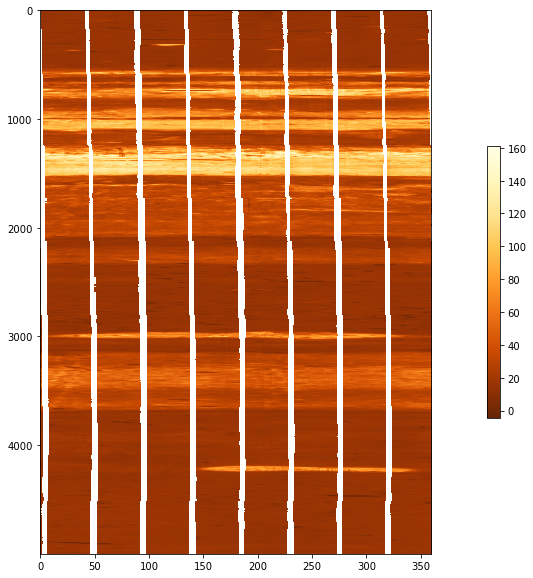

In [14]:
# Plot image
plt.figure(figsize = (20,10))
im = plt.imshow(image, cmap='YlOrBr_r', aspect=0.1) #, vmin=0, vmax=255)
plot = plt.colorbar(im, shrink=0.5)

## Interpolate the missing values

In [15]:
nb = shape[1]

x = np.arange(nb)
x_360 = np.linspace(0, nb, 360)

In [16]:
for i, row in enumerate(image):
    row_invalid = np.isnan(row)
    row_new = np.interp(x[row_invalid], x[~row_invalid], row[~row_invalid], period=nb)
    image[i, row_invalid] = row_new

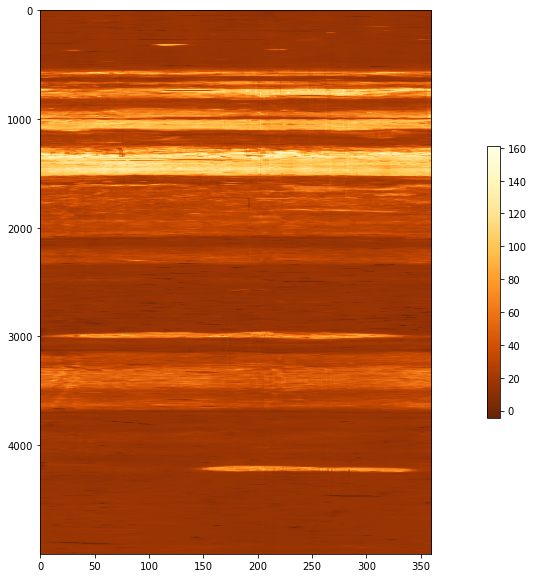

In [17]:
# Plot image
plt.figure(figsize = (20,10))
im = plt.imshow(image, cmap='YlOrBr_r', aspect=0.1)
plot = plt.colorbar(im, shrink=0.5)

## Resample over 360 bins

In [18]:
if nb !=360:
    image_360 = np.empty((image.shape[0], 360))
    for i, row in enumerate(image):
        image_360[i, :] = np.interp(x_360, x, row, period=360)
else:
    image_360 = image

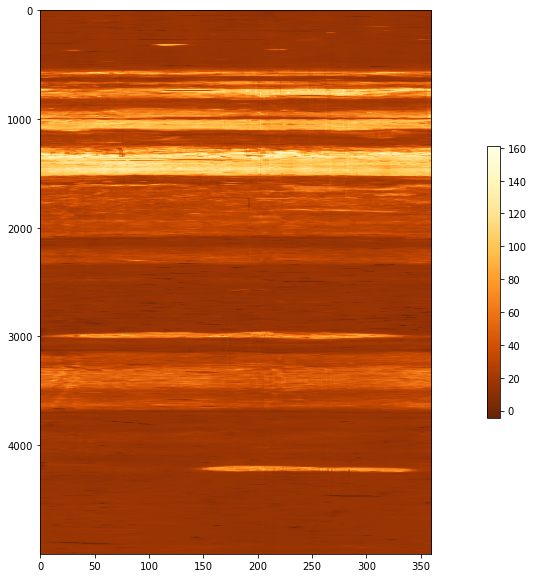

In [19]:
# Plot image
plt.figure(figsize = (20,10))
im = plt.imshow(image_360, cmap='YlOrBr_r', aspect=0.1)
plot = plt.colorbar(im, shrink=0.5)

## Compute distribution of values at each depth

In [20]:
# Choose the number of bins
nbins = 50

hist_360 = np.empty((shape[0], nbins))

for i, row in enumerate(image_360):
    hist, bin_edges = np.histogram(row, bins=nbins)
    hist_360[i, :] = hist

In [21]:
print(hist_360.shape)

(5000, 50)


In [22]:
fac = 20
nd_sub = int(shape[0]/fac)
hist_360_sub = np.empty((nd_sub, nbins))

In [23]:
for i in range(nd_sub):
#     print(i*fac, (i+1)*fac)
    hist_360_sub[i] = np.sum(hist_360[i*fac:(i+1)*fac, :], axis=0)/fac

In [24]:
shape_sub = hist_360_sub.shape
print(shape_sub)

(250, 50)


[ 80 238  41  35  96  31  54 108 139 155]


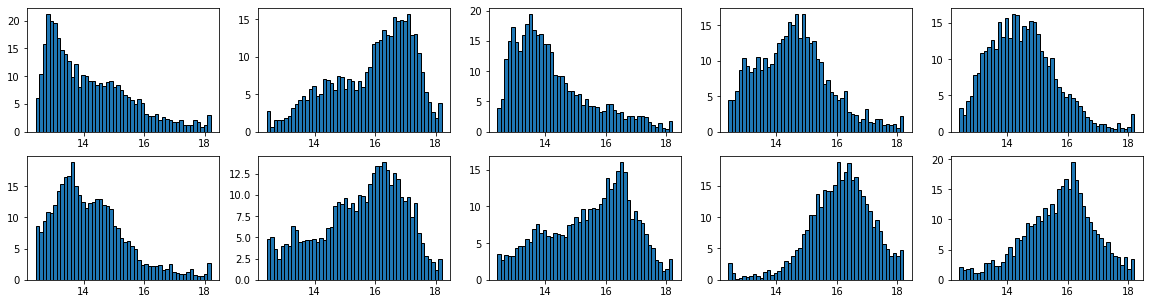

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
ax = ax.flatten()
depths = np.random.randint(0, shape_sub[0], 10)
print(depths)
for i, row in enumerate(depths):
    ax[i].bar(bin_edges[:-1], hist_360_sub[row, :], width=np.diff(bin_edges), ec="k", align="edge")

## K-means Clustering

In [26]:
from sklearn.cluster import KMeans
n_clusters=6
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(hist_360_sub)

In [27]:
def plot_clust(label_num):
    clust=hist_360_sub[kmeans.labels_ == label_num]
    fig, ax = plt.subplots(2, 5, figsize=(20, 5))
    ax = ax.flatten()
    depths = np.random.randint(0, clust.shape[0], 10)
    for i, row in enumerate(depths):
        ax[i].bar(bin_edges[:-1], clust[row, :], width=np.diff(bin_edges), ec="k", align="edge")

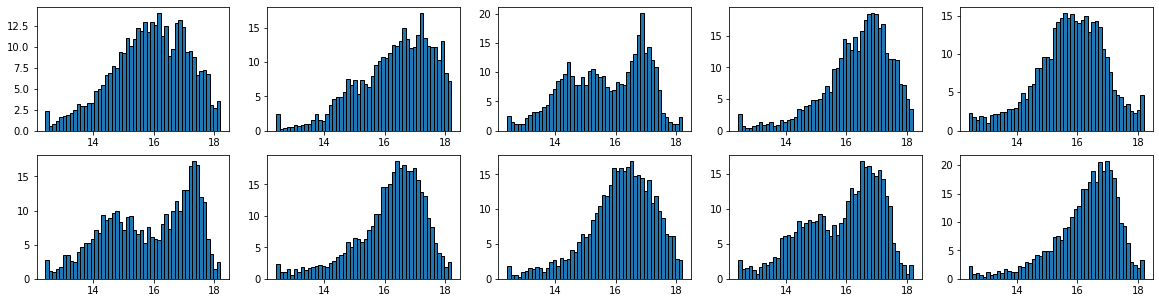

In [28]:
plot_clust(label_num=0)

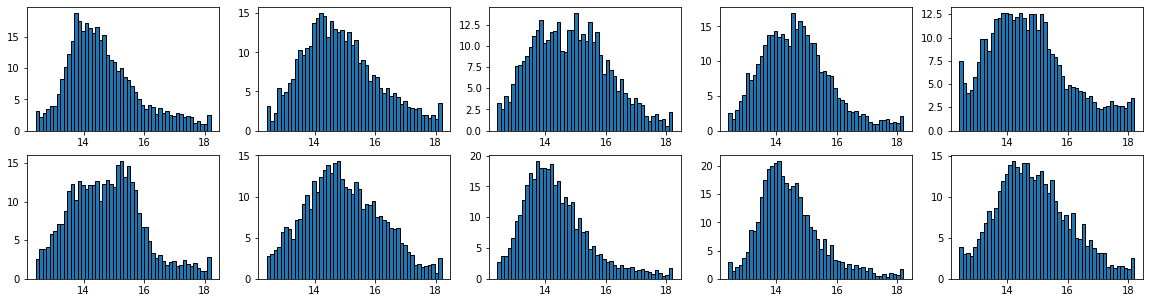

In [29]:
plot_clust(label_num=1)

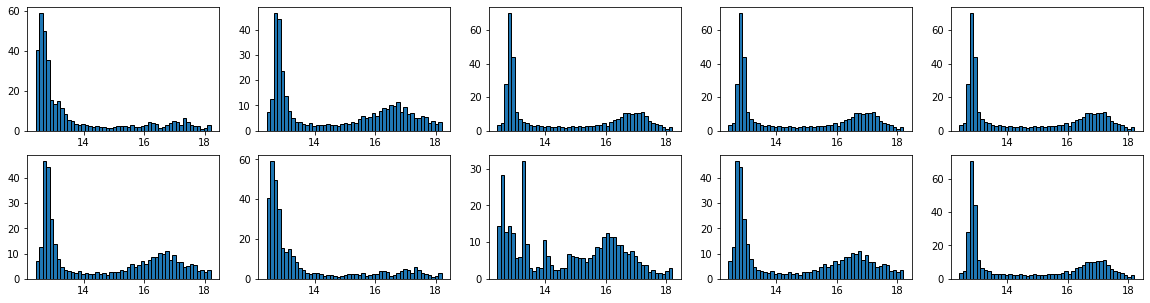

In [30]:
plot_clust(label_num=2)

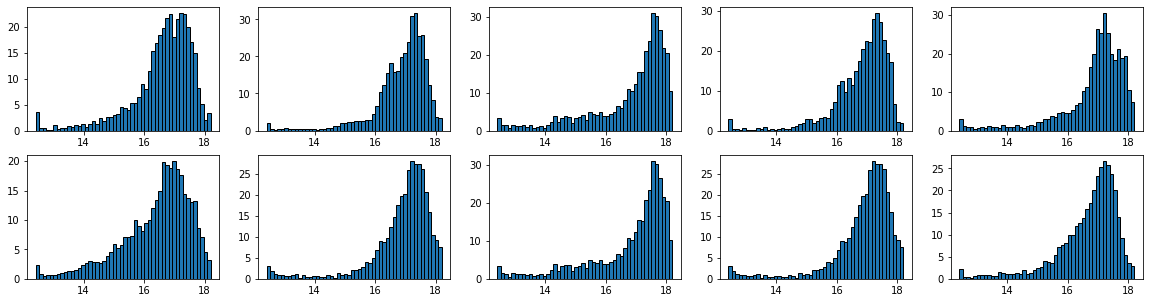

In [31]:
plot_clust(label_num=3)

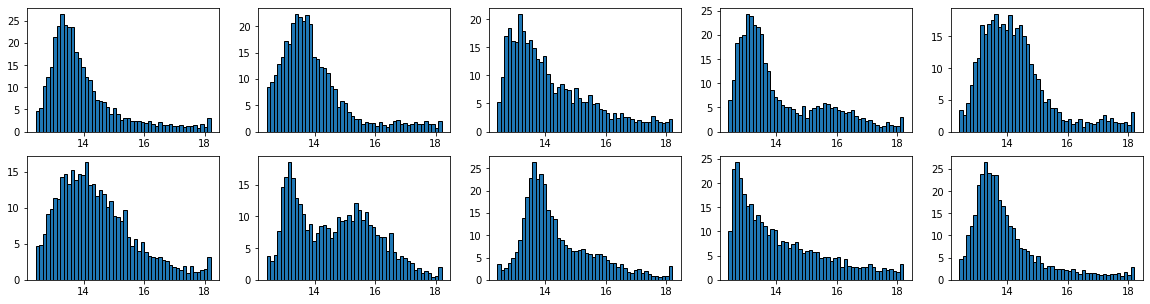

In [32]:
plot_clust(label_num=4)

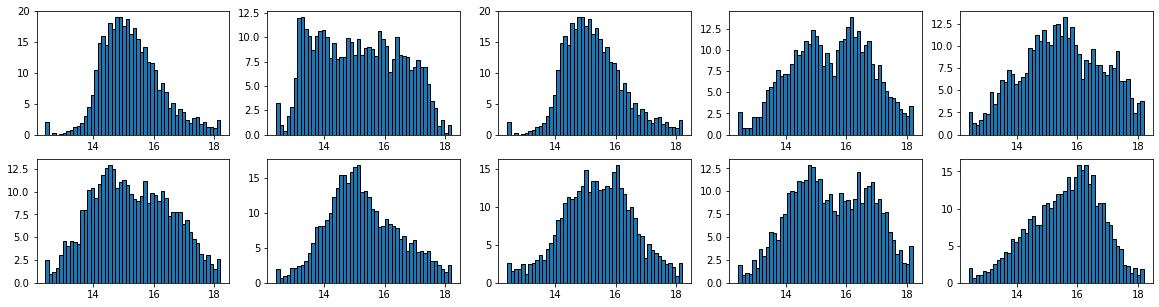

In [33]:
plot_clust(label_num=5)

In [35]:
# create array like the image but with the cluster labels
a=kmeans.labels_.ravel()
b = np.repeat(a, image_360.shape[0]/a.shape[0])
c= np.empty(shape=(b.shape[0],100))
for i in range(c.shape[1]):
    c[:,i] = b

In [36]:
# color
import matplotlib.colors as mcolors
vals = list(np.arange(0,n_clusters,1))
gp_defcols = ['#015482','#9f0052','#ffbe00','#728f02','#443988','#ff3f20','#325916','#5DA629']
color_lot = dict(zip(vals, gp_defcols[:n_clusters]))
cmap = mcolors.ListedColormap(gp_defcols)
norm = mcolors.Normalize(vmin=0, vmax=len(vals))

In [37]:
import matplotlib.gridspec as gridspec

In [38]:
def clustering_plot(c):
    transitions=[]
    for i in range(c.shape[0]-1):
        if c[i,0] != c[i+1,0]:
            transitions.append(i)

    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10), gridspec_kw = {'wspace':0, 'hspace':0})

    axes[0].imshow(image_360, cmap='YlOrBr_r', aspect=.1)
    axes[1].imshow(c, cmap=cmap, norm=norm, aspect=.2)#,norm=LogNorm(vmin=0.5, vmax=5))
    #ax[1].axis('off')
    #axes[1].hlines(np.array(transitions), xmin=0, xmax=99)
    fig.subplots_adjust(wspace=0, hspace=0)

## Clustering result

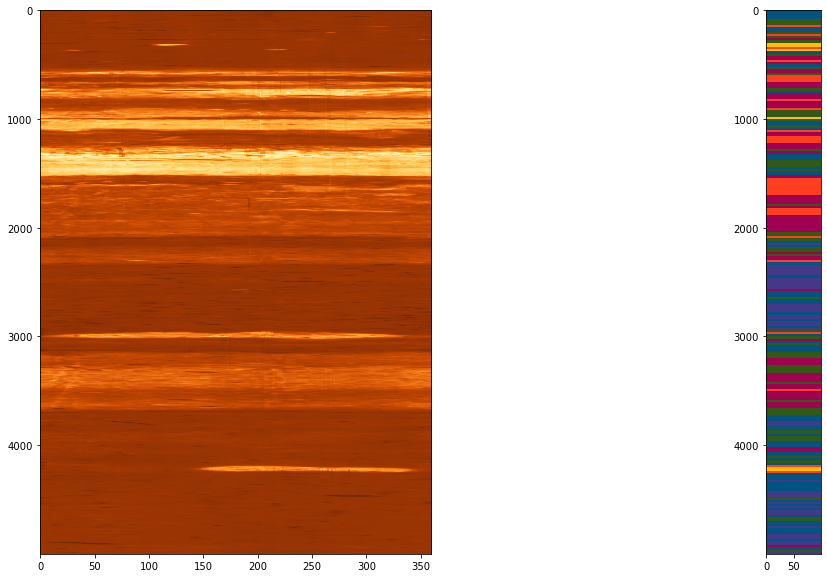

In [40]:
clustering_plot(c)

In [41]:
def clustering_plot2(c):
    transitions=[]
    start=3000
    stop=3700
    for i in range(c[start:stop,:].shape[0]-1):
        if c[start:stop,:][i,0] != c[start:stop,:][i+1,0]:
            transitions.append(i)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    #gs1 = gridspec.GridSpec(4, 4)
    #gs1.update(wspace=0.0, hspace=0.0)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],
             wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

    axes[0].imshow(image_360[start:stop,:], cmap='YlOrBr_r',aspect=.5)
    axes[0].hlines(np.array(transitions), xmin=0, xmax=359)
    axes[1].imshow(c[start:stop,:], cmap=cmap, norm=norm,aspect=.5)#,norm=LogNorm(vmin=0.5, vmax=5))
    axes[1].hlines(np.array(transitions), xmin=0, xmax=99)
    #ax[1].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

## Close up

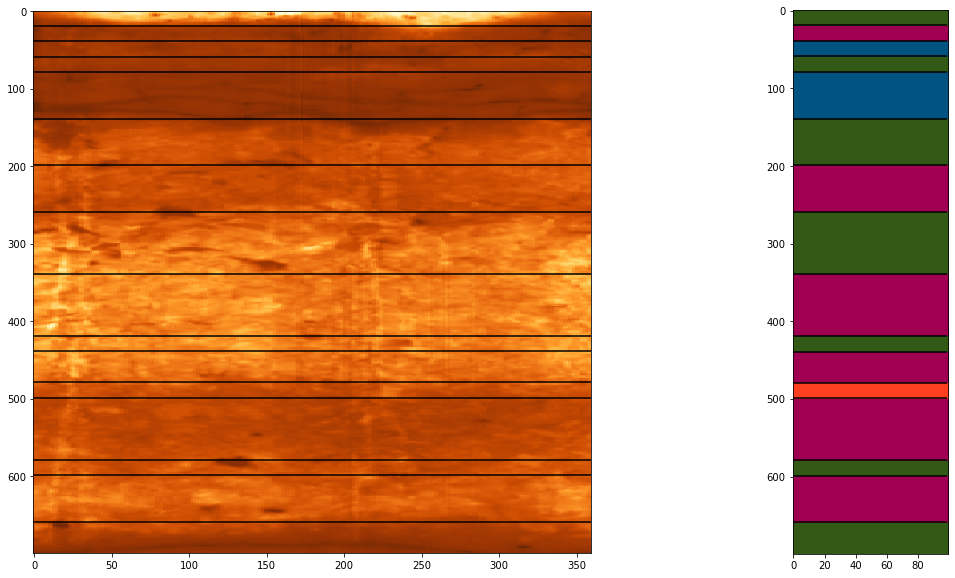

In [42]:
clustering_plot2(c)

In [46]:
titles = []
for val in vals:
    titles.append("cluster "+str(val))   
counts = np.unique(kmeans.labels_, return_counts=True)    
def plot_histograms(ar, bin_edges, n1=2, n2=5, titles=None, color_list=None):
    fig, ax = plt.subplots(n1, n2, figsize=(20, 5))
    ax = ax.flatten()
    for i in range(n1*n2):
        ax[i].bar(bin_edges[:-1], ar[i, :], width=np.diff(bin_edges), ec="k", align="edge", color=color_list[i], alpha=.8) 
        ax[i].set_title(titles[i])
        #ax[i].annotate(counts[1][i])
        ax[i].text(0.05, 0.8, 'n = '+str(counts[1][i]), style='italic',
        bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10}, transform=ax[i].transAxes)
    fig.tight_layout()

## Cluster centroids

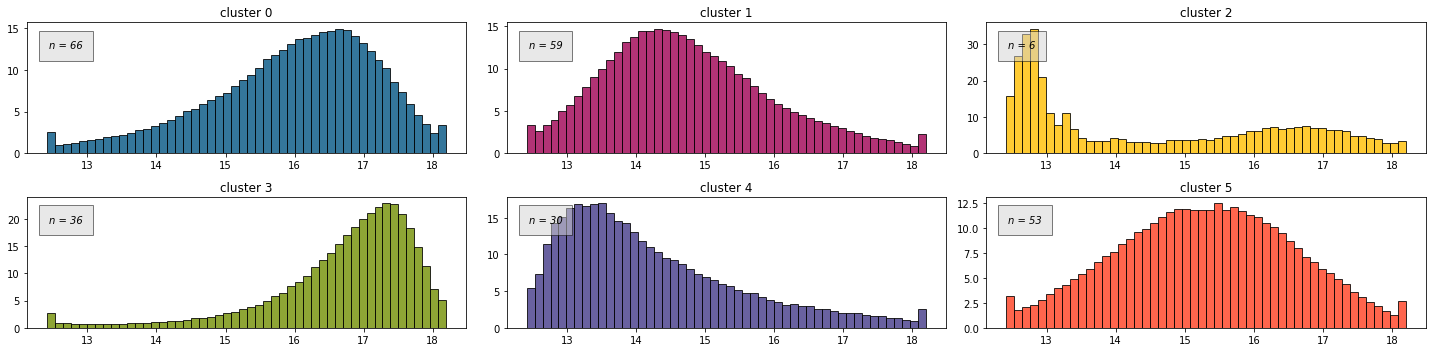

In [47]:
plot_histograms(kmeans.cluster_centers_, bin_edges, 2,int(n_clusters/2), titles, gp_defcols[:n_clusters])

## Save data

In [44]:
fn = f"hist/hist{well}"
np.save(fn, hist_360_sub)

In [45]:
!ls hist

hist0.npy hist1.npy hist2.npy


![Logo](images/logo.png)